# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [75]:
# import libraries
import pandas as pd
import re
from sqlalchemy import create_engine

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, coverage_error, f1_score, precision_score, recall_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /home/guischmitd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guischmitd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/guischmitd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table('categorized_messages', engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X = df['message']
target_cols = [col for col in df.columns if col not in ('id', 'message', 'original', 'genre')]
Y = df[target_cols]

In [15]:
for col in Y.columns:
    print()
    print(Y[col].value_counts())


1    19874
0     6115
Name: related, dtype: int64

0    21525
1     4464
Name: request, dtype: int64

0    25872
1      117
Name: offer, dtype: int64

0    15149
1    10840
Name: aid_related, dtype: int64

0    23909
1     2080
Name: medical_help, dtype: int64

0    24679
1     1310
Name: medical_products, dtype: int64

0    25265
1      724
Name: search_and_rescue, dtype: int64

0    25518
1      471
Name: security, dtype: int64

0    25130
1      859
Name: military, dtype: int64

0    25989
Name: child_alone, dtype: int64

0    24320
1     1669
Name: water, dtype: int64

0    23072
1     2917
Name: food, dtype: int64

0    23681
1     2308
Name: shelter, dtype: int64

0    25585
1      404
Name: clothing, dtype: int64

0    25386
1      603
Name: money, dtype: int64

0    25691
1      298
Name: missing_people, dtype: int64

0    25115
1      874
Name: refugees, dtype: int64

0    24797
1     1192
Name: death, dtype: int64

0    22548
1     3441
Name: other_aid, dtype: int64

0    24

### 2. Write a tokenization function to process your text data

In [67]:
def tokenize(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    # normalize (remove capitalization)
    text = text.lower()
    
    # remove URLs
    text = re.sub('(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)', 'urlplaceholder', text)
    
    # remove punctuation
    text = re.sub('\W', ' ', text)
    
    sentences = sent_tokenize(text)
    
    tokens = []
    for sent in sentences:
        tokens.extend([lemmatizer.lemmatize(word) for word in word_tokenize(sent) if word not in stop_words])
    
    return tokens

test_msg = X.sample(1).iloc[0]
print(test_msg)
tokenize(test_msg)

If a person needs to go to St Domingo and doesn't have a visa, is the ambassador open? It is us that will like to find it. 


['person',
 'need',
 'go',
 'st',
 'domingo',
 'visa',
 'ambassador',
 'open',
 'u',
 'like',
 'find']

In [68]:
test_msg = 'How will things be for tomorrow?'
print(test_msg)
tokenize(test_msg)


How will things be for tomorrow?


['thing', 'tomorrow']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [69]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [70]:
seed = 51
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=seed)

In [71]:
X_train.shape, y_train.shape

((18192,), (18192, 36))

In [72]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7f00883bd378>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [73]:
y_pred = pipeline.predict(X_test)

In [76]:
for i, col in enumerate(y_test.columns):
        print('*** Category:', col, '***')
        print(classification_report(y_test[col], y_pred[:, i]))

*** Category: related ***
              precision    recall  f1-score   support

           0       0.70      0.41      0.52      1829
           1       0.84      0.95      0.89      5968

    accuracy                           0.82      7797
   macro avg       0.77      0.68      0.70      7797
weighted avg       0.81      0.82      0.80      7797

*** Category: request ***
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6436
           1       0.84      0.50      0.63      1361

    accuracy                           0.90      7797
   macro avg       0.87      0.74      0.78      7797
weighted avg       0.89      0.90      0.89      7797

*** Category: offer ***
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7756
           1       0.00      0.00      0.00        41

    accuracy                           0.99      7797
   macro avg       0.50      0.50      0.50      779

In [80]:
precision_score?

Signature:
precision_score(
    y_true,
    y_pred,
    *,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)
Docstring:
Compute the precision.

The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
true positives and ``fp`` the number of false positives. The precision is
intuitively the ability of the classifier not to label as positive a sample
that is negative.

The best value is 1 and the worst value is 0.

Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

Parameters
----------
y_true : 1d array-like, or label indicator array / sparse matrix
    Ground truth (correct) target values.

y_pred : 1d array-like, or label indicator array / sparse matrix
    Estimated targets as returned by a classifier.

labels : array-like, default=None
    The set of labels to include when ``average != 'binary'``, and their
    order if ``average is None``. Labels present in the data can be
    exclud

In [88]:
def eval_metrics_per_category(y_test, y_pred, metrics=[precision_score, recall_score, f1_score, accuracy_score]):
    results = {}
    for i, col in enumerate(y_test.columns):
        results[col] = {}
        for metric in metrics:
            results[col].update({metric.__name__ : metric(y_test[col], y_pred[:, i])})
    return pd.DataFrame(results).T

res = eval_metrics_per_category(y_test, y_pred)

/home/guischmitd/Projects/udacity/disaster-response-classifier/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guischmitd/Projects/udacity/disaster-response-classifier/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guischmitd/Projects/udacity/disaster-response-classifier/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

<AxesSubplot:>

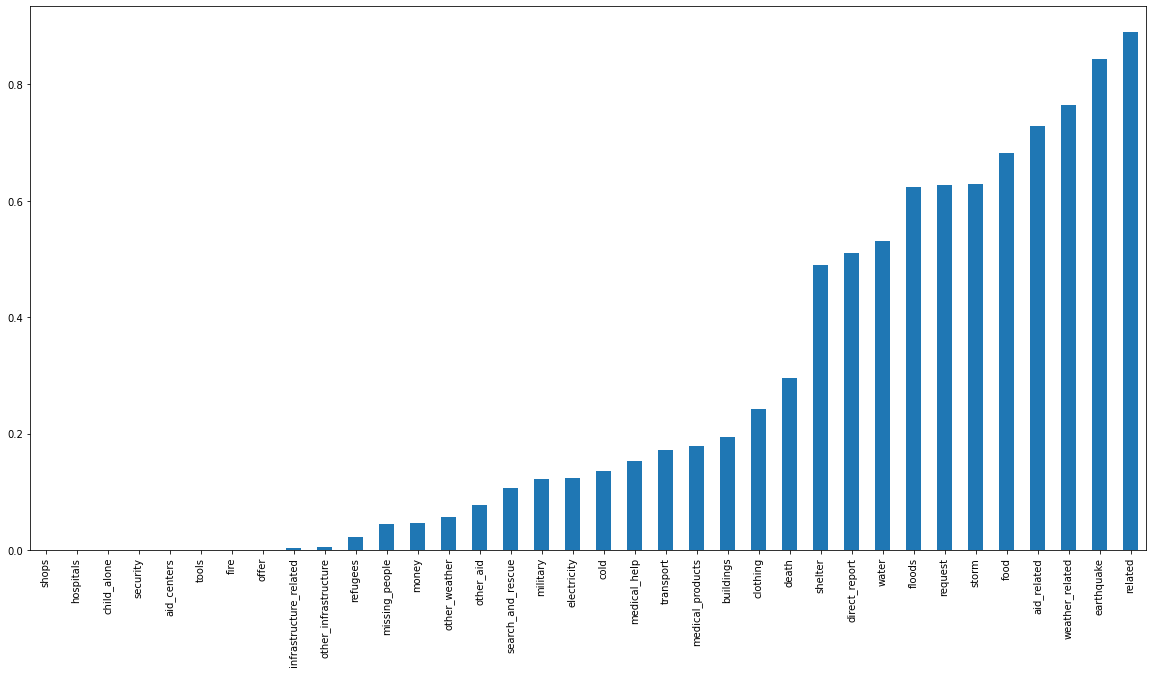

In [93]:
res.f1_score.sort_values().plot.bar(figsize=(20, 10))

<AxesSubplot:>

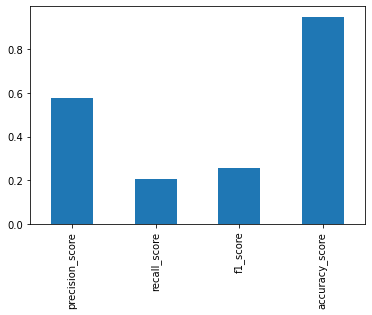

In [96]:
macro_res = res.mean()
macro_res.plot.bar()

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = 

cv = 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.